In [8]:
import sys
paths_to_add = ["/homes/vk223/ProjectFlood", "/home/vkhandekar/project_flood"]
for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from torch.utils.data import DataLoader
from model_runs.model_run_helpers import *
import matplotlib.pyplot as plt

In [2]:
model_path = "/homes/vk223/ProjectFlood/models/saved_models/convLSTM_separate_branches_9999_20240801.pt"
model, _, _, _ = load_checkpoint(model_path)

model.eval()
print(model.parameters())

<generator object Module.parameters at 0x7d26b95af5a0>


/homes/vk223/ProjectFlood/model_runs/model_run_helpers.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)
/vol/bitbucket/vk223/project_fl

In [6]:
os.environ["PROJECT_FLOOD_DATA"] = "/homes/vk223/ProjectFlood/static/imperial_data_paths.json"
print(os.environ["PROJECT_FLOOD_DATA"])
test_batch_size = 8
test_dataloader = get_dataloader("test_labels_path", resolution=256, preceding_rainfall_days=1, forecast_rainfall_days=1, 
                                  transform=None, batch_size=test_batch_size, shuffle=True, num_workers=4)
test_dataiter = iter(test_dataloader)
test_images, test_labels = next(test_dataiter)
# test_images, test_labels = test_set.get_random_batch(4)
# test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
# test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
outputs = model(test_images)
logits = torch.sigmoid(outputs)

/homes/vk223/ProjectFlood/static/imperial_data_paths.json


0.53422266 0.024923606
0.4869154 0.059042074
0.6443055 0.011336343
0.5179073 0.08965072
0.26772663 0.16916962
0.3676749 0.073199525
0.6502484 0.014786935
0.6638976 0.008000273


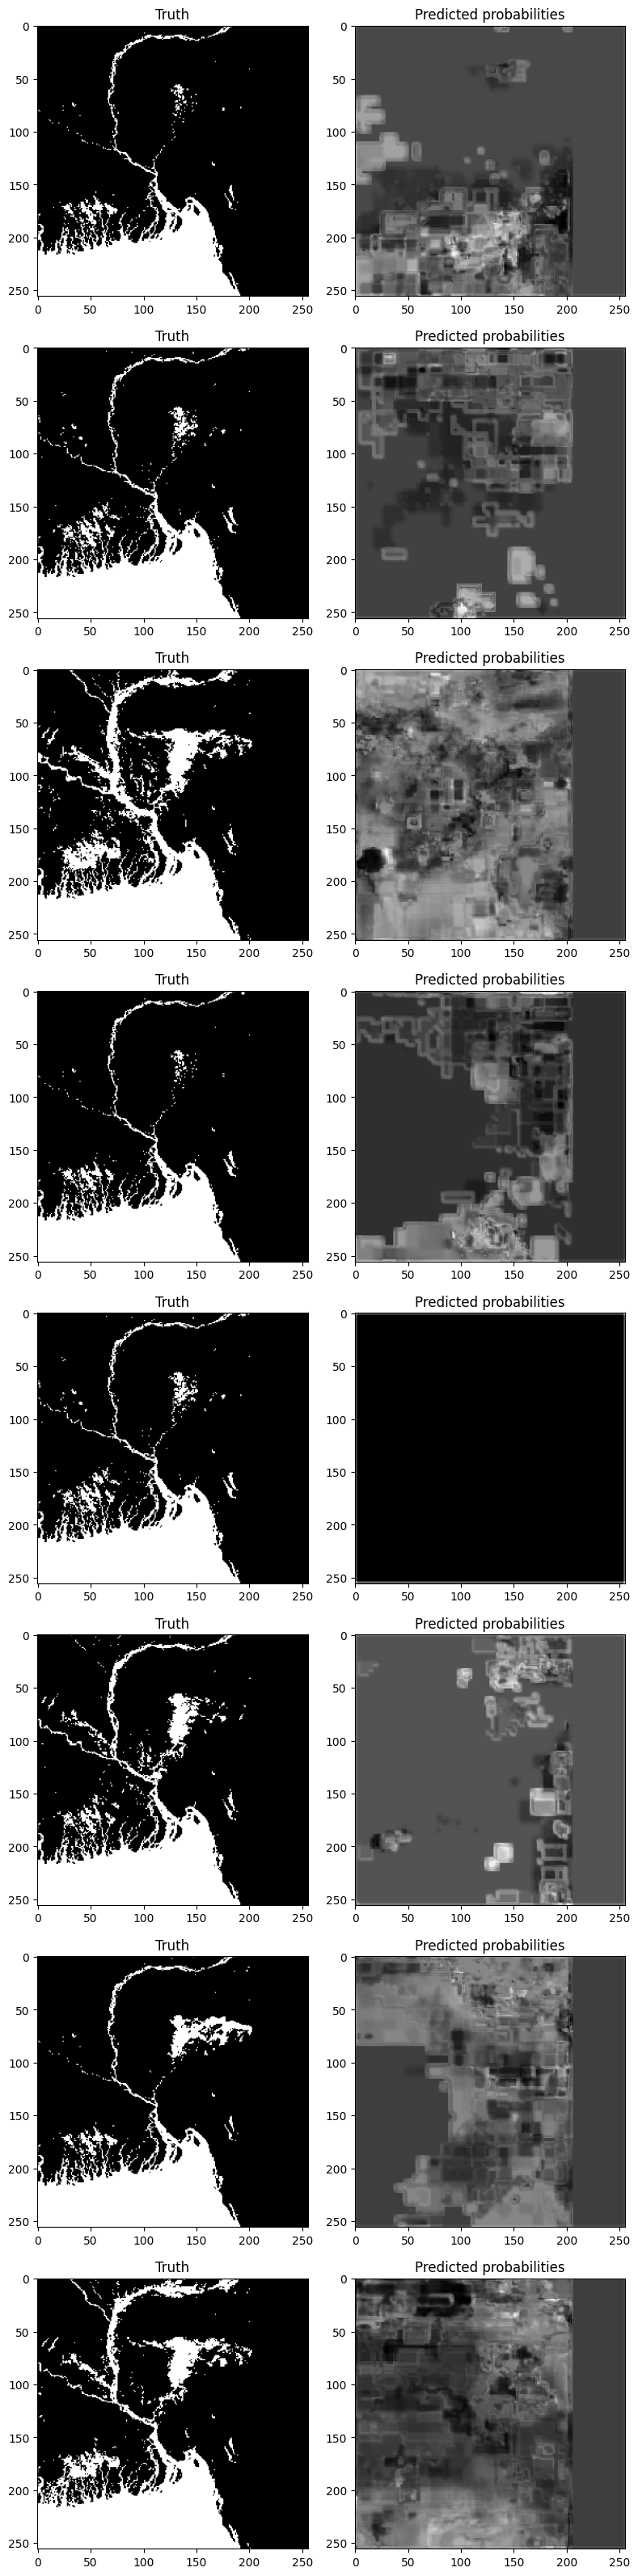

In [11]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("gray_scale", ["black", "white"])

fig, ax = plt.subplots(8, 2, figsize=(8, 32))
# label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
plt.tight_layout()
for i in range(test_batch_size):
    print(logits[i].squeeze(0).detach().cpu().numpy().max(), logits[i].squeeze(0).detach().cpu().numpy().min())
    ax[i, 0].imshow(test_labels[i].squeeze(0).cpu(), cmap=cmap)
    ax[i, 0].set_title("Truth")

    # get logit with largest soft max probability
    # probabilities = torch.softmax(test_logits[i].cpu(), dim=0)
    # best_prediction = torch.argmax(logits, dim=0)
    ax[i, 1].imshow(logits[i].squeeze(0).detach().cpu().numpy(), cmap=cmap)
    ax[i, 1].set_title("Predicted probabilities")